## Initial Local Creation of Bayesian Network

## HC + BIC

The experimentation and testing of the initial simple Bayesian Network on a smaller dataset for testing

In [1]:
import pgmpy
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import sys
sys.path.insert(0,"..")
from Data.DataPreprocessing import DataPreprocessing as myData
from pgmpy import estimators
from pgmpy.inference import VariableElimination
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
from pgmpy.metrics import correlation_score, log_likelihood_score, structure_score


c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data importing and preprocessing

In [10]:
loaded_data = myData.load_data()

#display(loaded_data)
data = myData.preprocess_data(loaded_data)
train_data, validation_data, test_data = myData.split_data(data,num_rows = 1000)

feature_states = myData.get_feature_states(data)
display(train_data)

c:\Users\zachs\Documents\CSHons\ResearchReport\Research_Code\Honours-Research\HC_differentScores\..\Data\DataPreprocessing.py:14: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../Data/accepted_2007_to_2018Q4.csv", engine='c')
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(esti

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,hardship_flag,disbursement_method,debt_settlement_flag
1024758,"(8800.0, 16600.0]",36 months,"(15.582, 20.718]","(350.054, 692.498]",D,1 year,OWN,0.0,Verified,2016,...,1.0,4.0,3.0,0.0,0.0,0.0,0.0,N,Cash,N
1683195,"(8800.0, 16600.0]",36 months,"(10.446, 15.582]","(350.054, 692.498]",B,< 1 year,RENT,0.0,Source Verified,2017,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,N,Cash,N
706827,"(24400.0, 32200.0]",36 months,"(5.284, 10.446]","(692.498, 1034.942]",A,10+ years,MORTGAGE,0.0,Source Verified,2016,...,0.0,4.0,3.0,0.0,0.0,1.0,1.0,N,Cash,N
17498,"(8800.0, 16600.0]",36 months,"(15.582, 20.718]","(350.054, 692.498]",D,2 years,MORTGAGE,0.0,Verified,2015,...,0.0,2.0,3.0,0.0,0.0,0.0,0.0,N,Cash,N
535428,"(16600.0, 24400.0]",36 months,"(10.446, 15.582]","(350.054, 692.498]",C,10+ years,OWN,0.0,Not Verified,2017,...,0.0,4.0,1.0,0.0,0.0,1.0,3.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009422,"(16600.0, 24400.0]",60 months,"(20.718, 25.854]","(350.054, 692.498]",E,< 1 year,RENT,0.0,Source Verified,2016,...,1.0,4.0,1.0,0.0,0.0,1.0,0.0,N,Cash,Y
670650,"(8800.0, 16600.0]",36 months,"(5.284, 10.446]","(350.054, 692.498]",A,10+ years,MORTGAGE,0.0,Not Verified,2016,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,N,Cash,N
1046462,"(8800.0, 16600.0]",36 months,"(15.582, 20.718]","(350.054, 692.498]",D,3 years,RENT,0.0,Not Verified,2016,...,1.0,2.0,0.0,0.0,0.0,3.0,0.0,N,Cash,Y
2181827,"(16600.0, 24400.0]",36 months,"(10.446, 15.582]","(350.054, 692.498]",C,3 years,MORTGAGE,0.0,Verified,2016,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,N,Cash,N


### Structure Learning

In [3]:
scoring_method = estimators.BicScore(data=train_data)
est = estimators.HillClimbSearch(data=train_data, use_cache = True)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_iter=int(1e3))

model = pgmpy.models.BayesianNetwork(estimated_model.edges())
model.add_nodes_from(estimated_model.nodes())



  6%|▋         | 65/1000 [00:19<04:43,  3.30it/s] 


88
13
['loan_amnt', 'installment', 'total_pymnt', 'term', 'grade', 'initial_list_status', 'int_rate', 'last_fico_range_high', 'loan_status', 'recoveries', 'debt_settlement_flag', 'last_pymnt_amnt', 'total_rec_int']


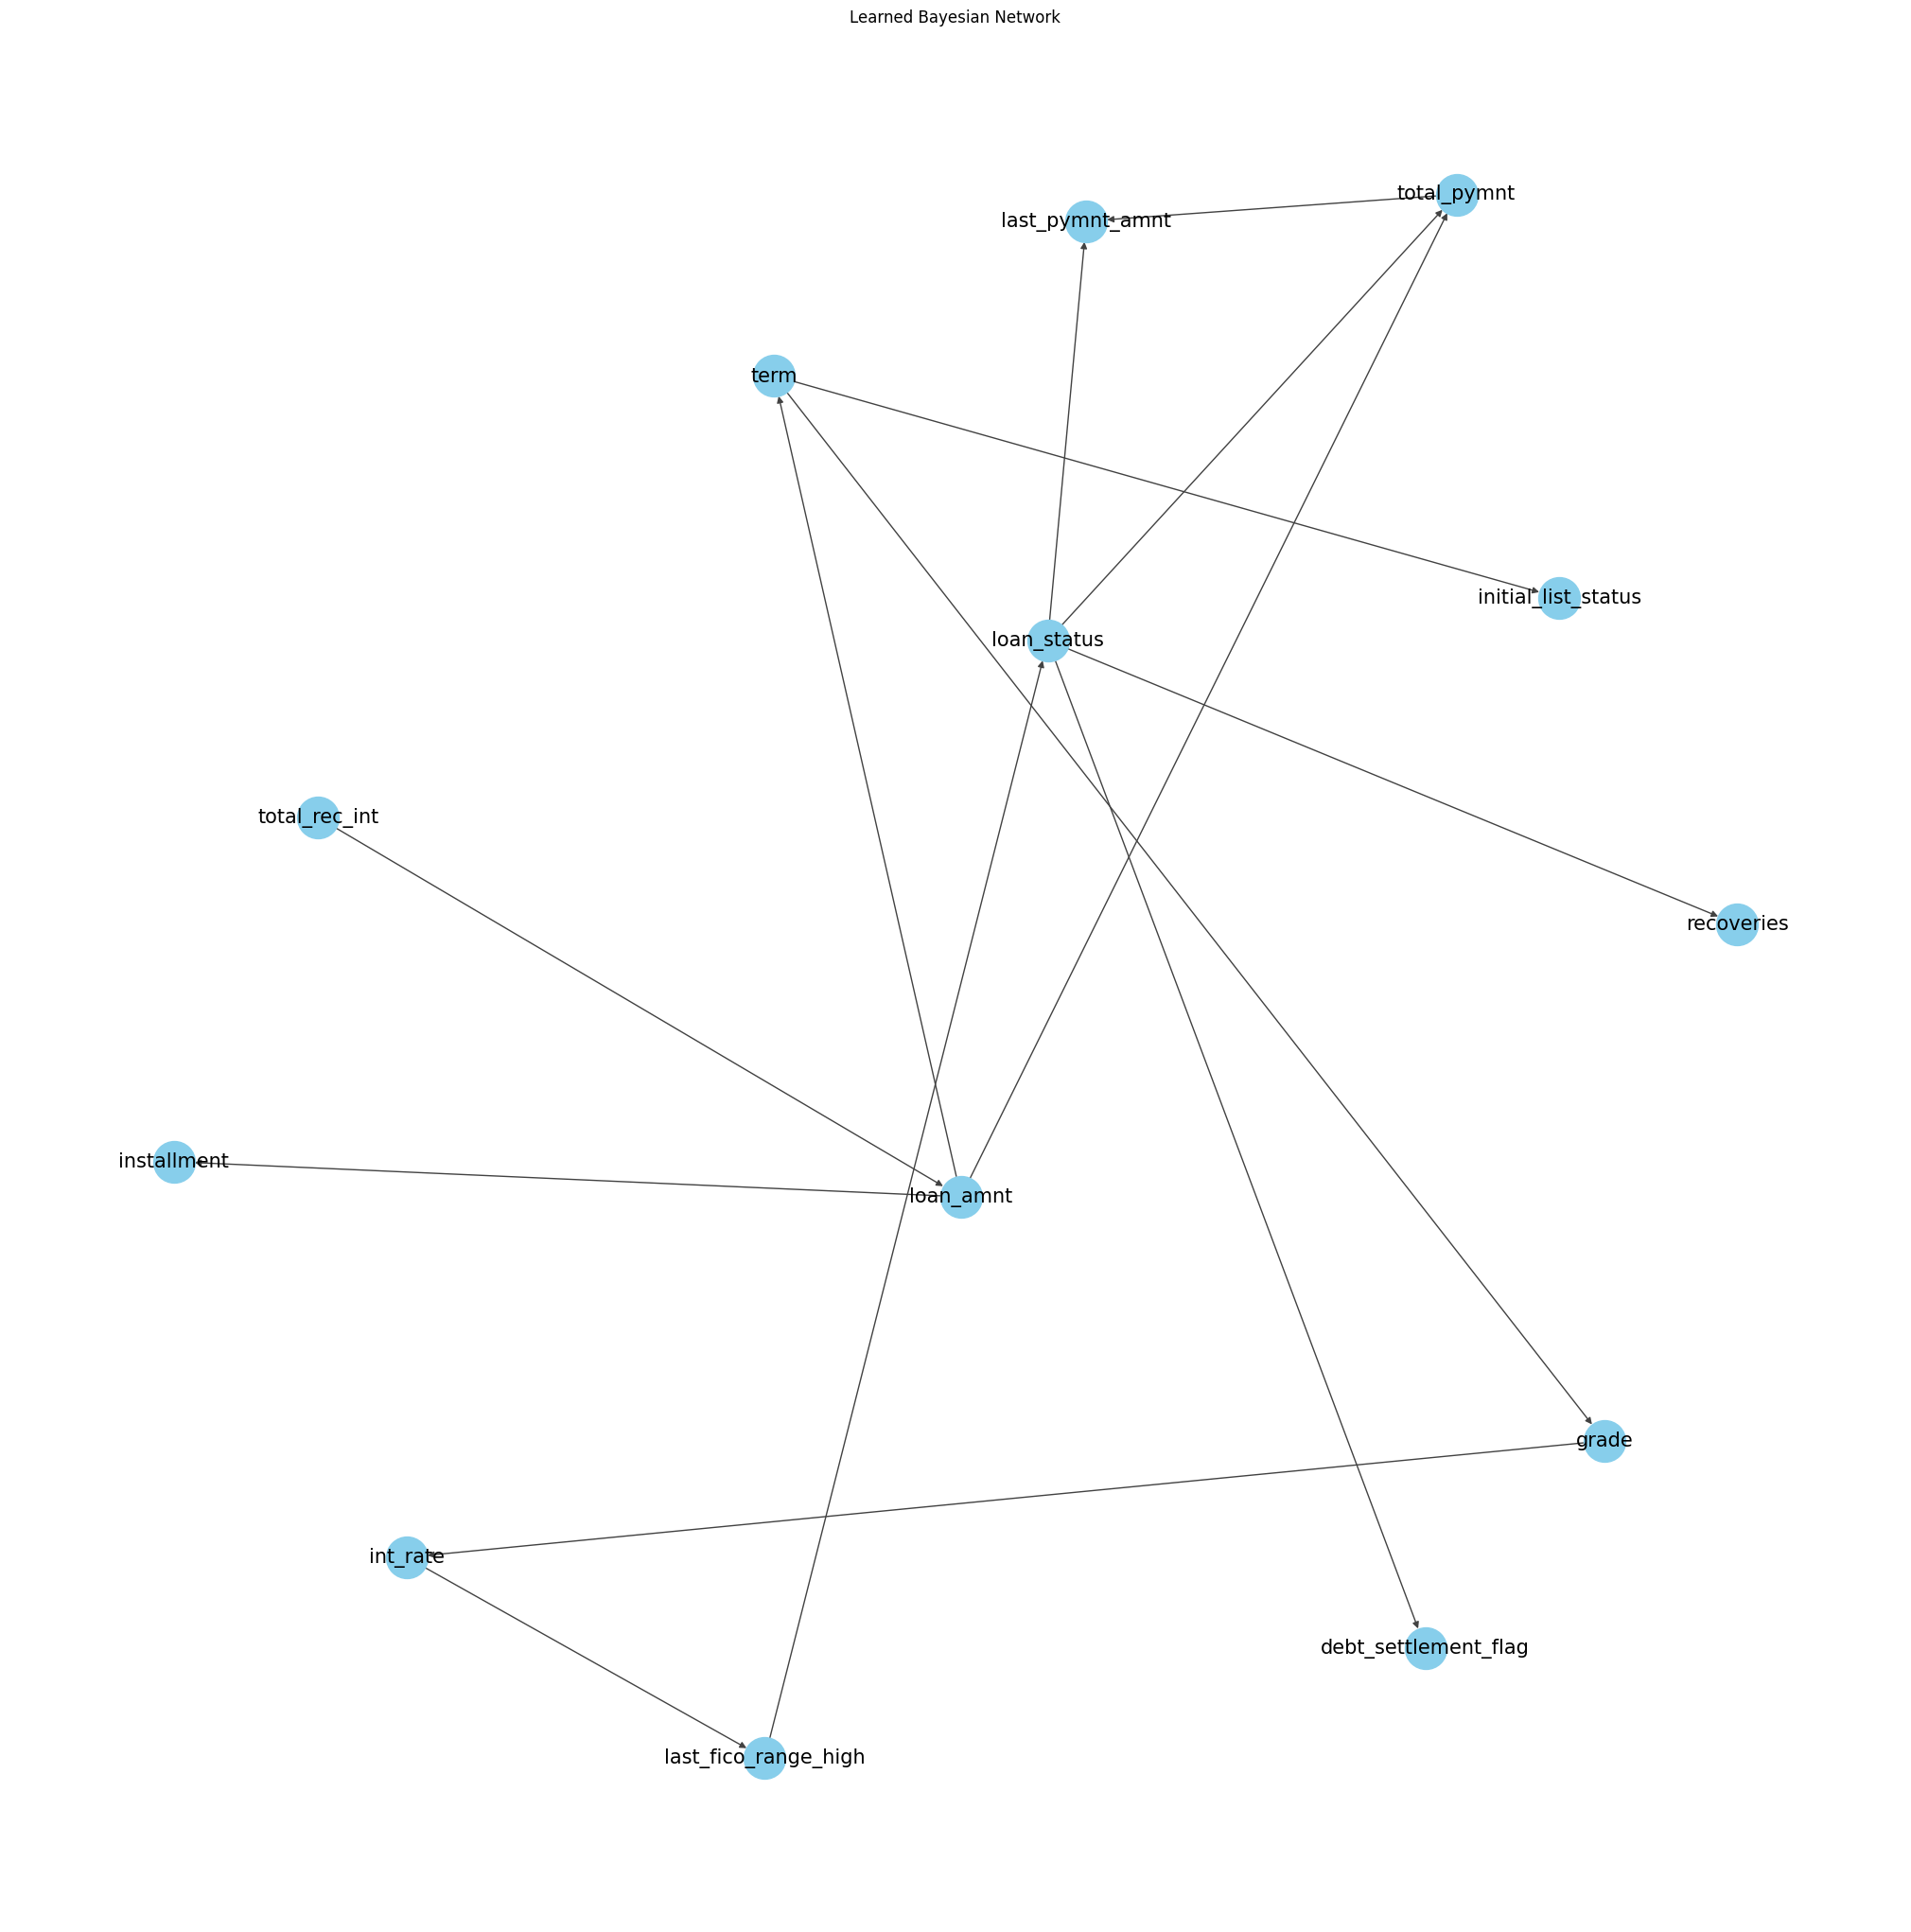

In [4]:
active_trail_nodes = model.active_trail_nodes('loan_status')['loan_status']
active_trail_nodes_list = list(active_trail_nodes)
original_nodes = list(model.nodes())
for node in original_nodes:
    if node not in active_trail_nodes_list:
        model.remove_node(node)
print(len(feature_states))
print(len(model.nodes()))
print(model.nodes())

nx_graph = nx.DiGraph(model.edges())
pos = nx.spring_layout(nx_graph,2)
plt.figure(figsize=(20, 20))
nx.draw(nx_graph, pos, with_labels=True, node_size=1000, node_color = 'skyblue', edge_color='#424242',font_size=15,font_color='black')
plt.title('Learned Bayesian Network')
plt.show()

###  Parameter Estimation

In [5]:
parameter_estimator = estimators.BayesianEstimator(model,train_data, state_names = feature_states)
parameters = parameter_estimator.get_parameters(n_jobs=6)

for i in range(len(parameters)):
    model.add_cpds(parameters[i])
    #print(parameters[i])

model.states

{'loan_amnt': ['(961.0, 8800.0]',
  '(24400.0, 32200.0]',
  '(16600.0, 24400.0]',
  '(8800.0, 16600.0]',
  '(32200.0, 40000.0]'],
 'total_rec_int': ['0.0', '1.0', '2.0', '3.0', '4.0'],
 'installment': ['(5.898, 350.054]',
  '(692.498, 1034.942]',
  '(350.054, 692.498]',
  '(1034.942, 1377.386]',
  '(1377.386, 1719.83]'],
 'total_pymnt': ['0.0', '3.0', '2.0', '1.0', '4.0'],
 'loan_status': ['Fully Paid', 'Charged Off'],
 'term': [' 36 months', ' 60 months'],
 'grade': ['C', 'B', 'F', 'A', 'E', 'D', 'G'],
 'initial_list_status': ['w', 'f'],
 'int_rate': ['(10.446, 15.582]',
  '(20.718, 25.854]',
  '(5.284, 10.446]',
  '(15.582, 20.718]',
  '(25.854, 30.99]'],
 'last_fico_range_high': ['(510.0, 680.0]',
  '(680.0, 850.0]',
  '(340.0, 510.0]',
  '(-0.85, 170.0]'],
 'recoveries': ['0.0', '1.0', '3.0', '2.0', '4.0'],
 'debt_settlement_flag': ['N', 'Y'],
 'last_pymnt_amnt': ['0.0', '2.0', '1.0', '3.0', '4.0']}

### Inference

In [6]:
from pgmpy.utils import compat_fns


def performInference(target_label_list, evidence_features, val_test_data, return_type: str):
    removed_attributes = set()
    predicted_values = []
    predicted_max_probabilities = []
    
    # get datapoints for the evidence
    validation_evidence_list = myData.get_evidence_list(test_data = val_test_data, target_label_list=target_label_list, evidence_features=evidence_features)
    
    # clean the evidence:
        # remove evidence features that are not in the Bayesian Network
    for i in range(len(validation_evidence_list)):
        for attribute in list(validation_evidence_list[i].keys()):
            if attribute not in model.nodes():
                removed_attributes.add(attribute)
                del validation_evidence_list[i][attribute]
    #print(removed_attributes)  
    
    # perform Variable Elimination with maximum a posteriori inference
    inference = VariableElimination(model)          
    for i in range(len(validation_evidence_list)):
        if return_type == "probability":
            posterior_distribution = inference.query(variables = target_label_list, evidence=validation_evidence_list[i], elimination_order="MinFill", joint=True, show_progress= False )
            #argmax = compat_fns.argmax(posterior_distribution.values)
            #assignment = posterior_distribution.assignment([argmax])[0]
            max = compat_fns.max(posterior_distribution.values)
            predicted_max_probabilities.append(max)
            
        elif return_type == "assignment":
            target_variables_result = inference.map_query(target_label_list, evidence = validation_evidence_list[i], elimination_order="MinFill", show_progress= False) 
            predicted_values.append(target_variables_result)
        else:
            raise ValueError
        
    if return_type == "probability":
        return predicted_max_probabilities
    elif return_type == "assignment":
        return predicted_values

In [7]:
  
very_basic_evidence_features = ["annual_inc","emp_length", "grade", "verification_status","fico_range_high","purpose","dti", "home_ownership", "tot_cur_bal", "pub_rec_bankruptcies"]

basic_evidence_features = ["annual_inc", "emp_length", "grade", "home_ownership", "verification_status", "last_fico_range_high", "fico_range_high", "purpose", "dti", "application_type", "delinq_2yrs", "avg_cur_bal", "tot_cur_bal", "pub_rec_bankruptcies", "mort_acc", "num_il_tl", "num_rev_accts", "total_bal_ex_mort"]

more_detailed_evidence_features = ["annual_inc", "emp_length", "grade", "home_ownership", "verification_status", "last_fico_range_high", "fico_range_high", "purpose", "dti", "application_type", "delinq_2yrs", "avg_cur_bal", "tot_cur_bal", "pub_rec_bankruptcies", "mort_acc", "num_il_tl", "num_rev_accts", "total_bal_ex_mort", "revol_bal", "num_actv_rev_tl","num_op_rev_tl","max_bal_bc","total_rev_hi_lim","total_bal_il","open_acc","total_acc","tax_liens","pub_rec","num_bc_tl","earliest_cr_line","pct_tl_nvr_dlq","acc_now_delinq"]

advanced_evidence_features =  ["annual_inc", "emp_length", "grade", "home_ownership", "verification_status", "last_fico_range_high", "fico_range_high", "purpose", "dti", "application_type", "delinq_2yrs", "avg_cur_bal", "tot_cur_bal", "pub_rec_bankruptcies", "mort_acc", "num_il_tl", "num_rev_accts", "total_bal_ex_mort", "revol_bal", "num_actv_rev_tl","num_op_rev_tl","max_bal_bc","total_rev_hi_lim","total_bal_il","open_acc","total_acc","tax_liens","pub_rec","num_bc_tl","earliest_cr_line","pct_tl_nvr_dlq","acc_now_delinq","revol_util","all_util","bc_util","total_cu_tl","total_bc_limit","num_actv_bc_tl","num_bc_sats","percent_bc_gt_75","num_tl_30dpd","num_tl_90g_dpd_24m","num_tl_120dpd_2m","num_accts_ever_120_pd"]

all_customer_info_evidence_features =  ["annual_inc", "emp_length", "grade", "home_ownership", "verification_status", "last_fico_range_high", "fico_range_high", "purpose", "dti", "application_type", "delinq_2yrs", "avg_cur_bal", "tot_cur_bal", "pub_rec_bankruptcies", "mort_acc", "num_il_tl", "num_rev_accts", "total_bal_ex_mort", "revol_bal", "num_actv_rev_tl","num_op_rev_tl","max_bal_bc","total_rev_hi_lim","total_bal_il","open_acc","total_acc","tax_liens","pub_rec","num_bc_tl","earliest_cr_line","pct_tl_nvr_dlq","acc_now_delinq","revol_util","all_util","bc_util","total_cu_tl","total_bc_limit","num_actv_bc_tl","num_bc_sats","percent_bc_gt_75","num_tl_30dpd","num_tl_90g_dpd_24m","num_tl_120dpd_2m","num_accts_ever_120_pd","open_il_12m","open_il_24m","num_tl_op_past_12m","open_acc_6m","acc_open_past_24mths","open_rv_12m","open_rv_24m","mo_sin_rcnt_tl","mths_since_recent_bc","mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","mo_sin_old_il_acct","mths_since_recent_inq","inq_fi","inq_last_6mths","inq_last_12m","title","bc_open_to_buy"]


    
# set the target features and evidence features
loan_structure_target_list = ["int_rate","term","installment"] 
evidence_features = very_basic_evidence_features
   
# adjust list if loan amount is evidence or a target
    # this will result in the model predicting the most likely loan amount for the borrower
#loan_structure_target_list.append('loan_amnt')
    # this will result in the loan amount being the original loan amount for each data point
evidence_features.append('loan_amnt')

map_probabilities = performInference(target_label_list = loan_structure_target_list, evidence_features= evidence_features, val_test_data = validation_data, return_type = "probability")    
map_assignments = performInference(target_label_list = loan_structure_target_list, evidence_features= evidence_features, val_test_data = validation_data, return_type = "assignment")   
print("Predicted assignments from MAP Query:\n") 
print(map_assignments)
print("\nPredicted probabilities for assignments from MAP Query:\n")
print(map_probabilities)

Predicted assignments from MAP Query:

[{'int_rate': '(10.446, 15.582]', 'installment': '(350.054, 692.498]', 'term': ' 36 months'}, {'int_rate': '(15.582, 20.718]', 'installment': '(350.054, 692.498]', 'term': ' 36 months'}, {'installment': '(350.054, 692.498]', 'term': ' 36 months', 'int_rate': '(5.284, 10.446]'}, {'installment': '(1034.942, 1377.386]', 'term': ' 36 months', 'int_rate': '(5.284, 10.446]'}, {'int_rate': '(10.446, 15.582]', 'installment': '(5.898, 350.054]', 'term': ' 36 months'}, {'installment': '(350.054, 692.498]', 'term': ' 36 months', 'int_rate': '(5.284, 10.446]'}, {'int_rate': '(15.582, 20.718]', 'installment': '(350.054, 692.498]', 'term': ' 60 months'}, {'installment': '(350.054, 692.498]', 'term': ' 36 months', 'int_rate': '(5.284, 10.446]'}, {'installment': '(1034.942, 1377.386]', 'term': ' 36 months', 'int_rate': '(10.446, 15.582]'}, {'int_rate': '(5.284, 10.446]', 'installment': '(5.898, 350.054]', 'term': ' 36 months'}, {'int_rate': '(15.582, 20.718]', 'i

## Testing

### Log-Likelihood

#### Log-Likelihood of model
#### ie P( data | model)

##### Full Distribution

In [8]:
# Do not print warnings
import logging
from pgmpy.global_vars import logger
logger.setLevel(logging.ERROR)


difference = list(set(validation_data.columns) - set(model.nodes()))
missing_features = []
for missing_feature in difference:
    missing_features.append(missing_feature)
    
val_data_removed_missing_features = validation_data.drop(missing_features, axis=1, inplace=False)

log_likelihood_val_data = log_likelihood_score(model, val_data_removed_missing_features)

print("Val Data Log likelihood score: " + str(log_likelihood_val_data))

Val Data Log likelihood score: -1723.4192584932982


##### P(loan structure | customer's info, loan_status = fully_paid) 

Log-likelihood of the probability of P(loan structure | customer's info, loan_status = fully_paid) 

To get this:
- use variable elimination/ exact inference to get the maximum a posteriori probability of P(loan structure | customer's info, loan_status = fully_paid)  for each data point
- get the product of all of probabilities 
- get the log of the product of the probabilities.

In [9]:
map_probabilities = performInference(target_label_list = loan_structure_target_list, evidence_features= very_basic_evidence_features, val_test_data = validation_data, return_type = "probability")  
map_probabilities = np.array(map_probabilities)
log_probabilities = np.log(map_probabilities)

log_likelihood_target_distribution = np.sum(log_probabilities)
print(log_likelihood_target_distribution)

-162.68016327379434
